## 정확도

In [2]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

In [3]:
class MyFakeClassifier(BaseEstimator):
    def fit(self, X ,y):
        pass
    
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [4]:
digits= load_digits()

y= (digits.target==7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [7]:
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

fakeclf= MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred=fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test,fakepred)))

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


## 오차 행렬

In [8]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

## 정밀도와 재현율

[데이터셋 출처](https://www.kaggle.com/c/titanic/data)

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [3]:
from sklearn import preprocessing

def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

def format_features(df):
    df['Cabin']=df['Cabin'].str[:1]
    features=['Cabin' , 'Sex' , 'Embarked']
    for feature in features:
        le=preprocessing.LabelEncoder()
        le=le.fit(df[feature])
        df[feature]=le.transform(df[feature])
    return df

def transform_features(df):
    df=fillna(df)
    df=drop_features(df)
    df=format_features(df)
    return df

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

titanic_df = pd.read_csv('./train.csv')
y_titanic_df=titanic_df['Survived']
X_titanic_df=titanic_df.drop('Survived', axis=1)
X_titanic_df=transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,test_size=0.20, random_state=11)
lr_clf=LogisticRegression()

lr_clf.fit(X_train,y_train)
pred=lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.849162, 정밀도: 0.7742, 재현율: 0.7869


C:\Users\2002t\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 정밀도 - 재현율 트레이드오프

In [6]:
import numpy as np
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)

print('pred_proba() 결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:',pred_proba[:3])

pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])  

pred_proba() 결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.46161968 0.53838032]
 [0.87858765 0.12141235]
 [0.87723954 0.12276046]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46161968 0.53838032 1.        ]
 [0.87858765 0.12141235 0.        ]
 [0.87723954 0.12276046 0.        ]]


In [7]:
from sklearn.metrics import precision_recall_curve

pred_proba_class1=lr_clf.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임계값 배열의 Shape:', thresholds.shape)

thr_index= np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index],2))

print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임계값 배열의 Shape: (143,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값:  [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플 임계값별 정밀도:  [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 재현율:  [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


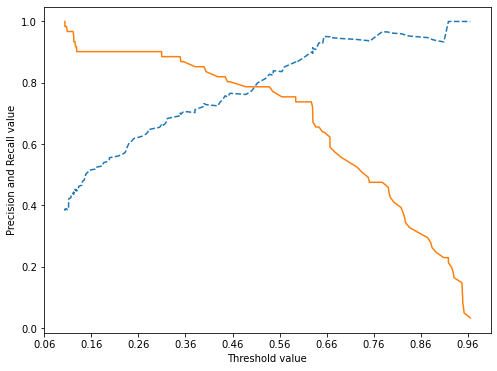

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

## F1 Score

In [9]:
from sklearn.preprocessing import Binarizer
from sklearn.metrics import f1_score

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임계값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)
    


def get_clf_eval(y_test, pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test,pred)
    
    f1= f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}\n'.format(accuracy, precision, recall, f1))
    
thresholds=[0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba= lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임계값: 0.4
오차 행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361, F1:0.7786

임계값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1:0.7840

임계값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1:0.7805

임계값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1:0.7931

임계값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1:0.8036



## ROC Curve & AUC Score

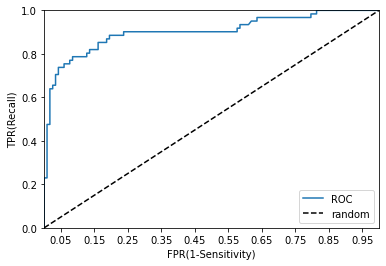

In [11]:
from sklearn.metrics import roc_curve

def roc_curve_plot(y_test, pred_proba_c1):

    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    
    plt.plot(fprs, tprs, label='ROC')
    
    plt.plot([0,1],[0,1], 'k--', label='random')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1-Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:,1])

In [12]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score=roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.9024


## 피마 인디언 당뇨병 예측

[데이터셋 출처](https://www.kaggle.com/uciml/pima-indians-diabetes-database)

### 데이터 분석

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data= pd.read_csv('diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [14]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [19]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## 데이터 전처리

In [21]:
zero_features=['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features]=diabetes_data[zero_features].replace(0, mean_zero_features)


### 예측 모델(로지스틱 회귀)

In [16]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test,pred)
    f1= f1_score(y_test, pred)
    roc_auc= roc_auc_score(y_test, pred_proba)
    
    print('오차 행렬')
    print(confusion)
    
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\ F1:{3:.4f}, AUC:{4:.4f}\n'.format(accuracy, precision, recall, f1,roc_auc))

In [22]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=156, stratify=y)

lr_clf=LogisticRegression()
lr_clf.fit(X_train, y_train)
pred= lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[90 10]
 [20 34]]
정확도: 0.8052, 정밀도: 0.7727, 재현율: 0.6296,\ F1:0.6939, AUC:0.8452



C:\Users\2002t\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


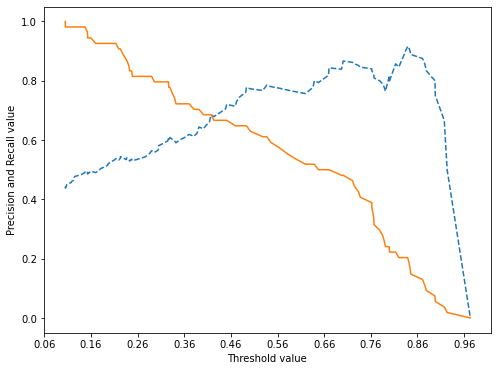

In [24]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]
precision_recall_curve_plot(y_test, pred_proba_c1)

In [26]:
binarizer = Binarizer(threshold=0.48)

pred_th_048 =binarizer.fit_transform(pred_proba[:, 1].reshape(-1,1))

get_clf_eval(y_test, pred_th_048, pred_proba[:, 1])

오차 행렬
[[89 11]
 [19 35]]
정확도: 0.8052, 정밀도: 0.7609, 재현율: 0.6481,\ F1:0.7000, AUC:0.8452

